In [1]:
library(corrplot)
library(ggplot2)
library(tidyr)
library(dplyr)
library(purrr)
library(GGally)
library(MASS)
library(caret)
library(glmnet)
library(Rcpp)
library(randomForest)
library(doParallel)
library(xgboost)

corrplot 0.92 loaded


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-6

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: foreach


Attaching packa

We'll analyze the Kaggle House Prices dataset and predict the prices of houses.

In [3]:
train_data <- read.csv("data/train.csv")
test_data <- read.csv("data/test.csv")

Let's start by taking at look at which variables are available in the dataset.

In [4]:
str(train_data)

'data.frame':	1460 obs. of  81 variables:
 $ Id           : int  1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass   : int  60 20 60 70 60 50 20 60 50 190 ...
 $ MSZoning     : chr  "RL" "RL" "RL" "RL" ...
 $ LotFrontage  : int  65 80 68 60 84 85 75 NA 51 50 ...
 $ LotArea      : int  8450 9600 11250 9550 14260 14115 10084 10382 6120 7420 ...
 $ Street       : chr  "Pave" "Pave" "Pave" "Pave" ...
 $ Alley        : chr  NA NA NA NA ...
 $ LotShape     : chr  "Reg" "Reg" "IR1" "IR1" ...
 $ LandContour  : chr  "Lvl" "Lvl" "Lvl" "Lvl" ...
 $ Utilities    : chr  "AllPub" "AllPub" "AllPub" "AllPub" ...
 $ LotConfig    : chr  "Inside" "FR2" "Inside" "Corner" ...
 $ LandSlope    : chr  "Gtl" "Gtl" "Gtl" "Gtl" ...
 $ Neighborhood : chr  "CollgCr" "Veenker" "CollgCr" "Crawfor" ...
 $ Condition1   : chr  "Norm" "Feedr" "Norm" "Norm" ...
 $ Condition2   : chr  "Norm" "Norm" "Norm" "Norm" ...
 $ BldgType     : chr  "1Fam" "1Fam" "1Fam" "1Fam" ...
 $ HouseStyle   : chr  "2Story" "1Story" "2Story" "2Story" ...


We have a mix of numerical and categorical variables with missing values. Let's take a look at the sale price variable, which is the target variable.

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


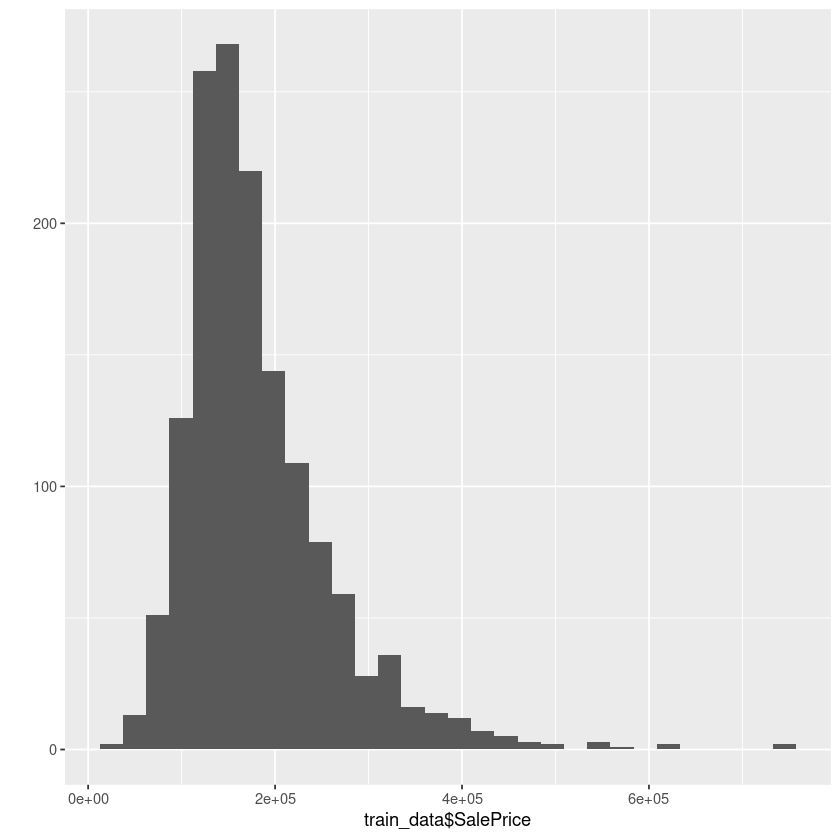

In [5]:
qplot(train_data$SalePrice)

It's clear that the distribution of SalePrice has a positive skew and is not exactly normal.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 348 rows containing non-finite values (`stat_bin()`).”


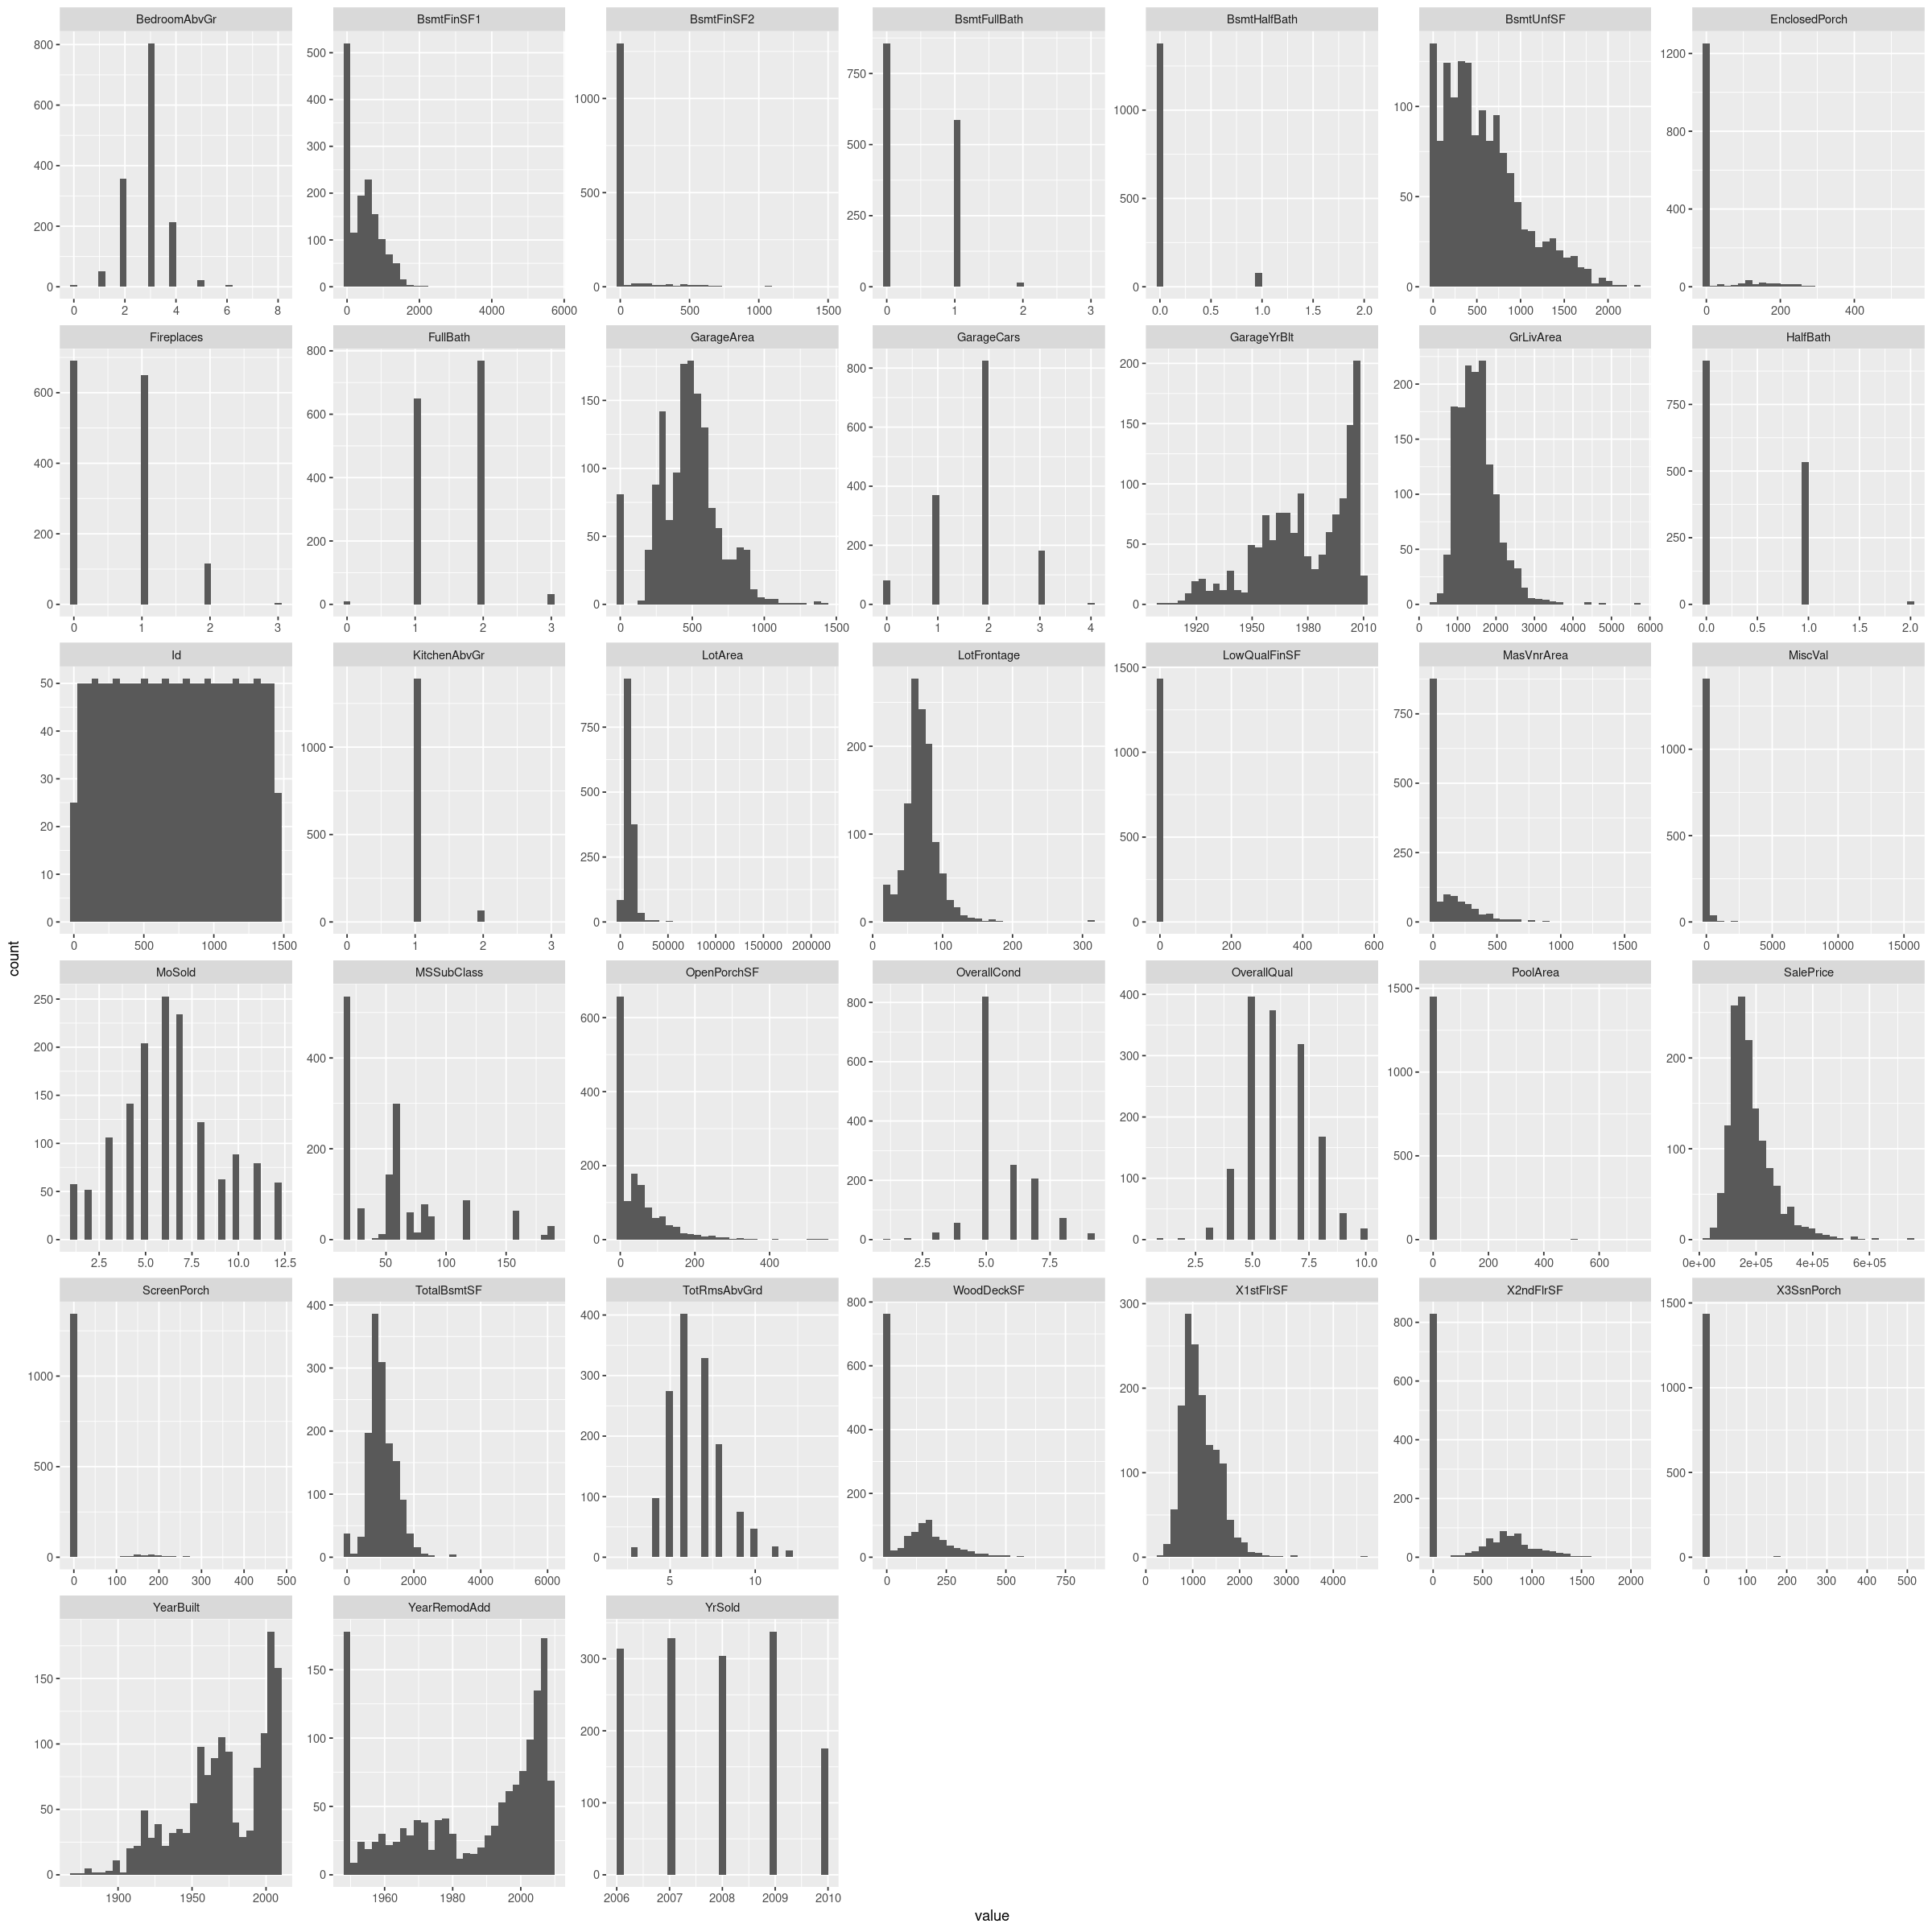

In [6]:
options(repr.plot.width = 20, repr.plot.height = 20)
nums <- unlist(lapply(train_data, is.numeric), use.names = FALSE)

train_data %>%
select_if(is.numeric) %>%
gather(cols, value) %>%
ggplot(aes(value)) + geom_histogram() + facet_wrap(~cols, scales = "free")

options(repr.plot.width = 12, repr.plot.height = 12)

Well, many variables are not normally distributed. Also, many of them seem to be count variables with discrete values. Some have very strong skew and kurtosis, while others have zero-inflated distributions. These facts are important to understand before fitting a model.

Let's also have a look at correlation matrix plots to see if we can spot some obvious or interesting correlations. We'll use Spearman correlation since most variables are not normally distributed.

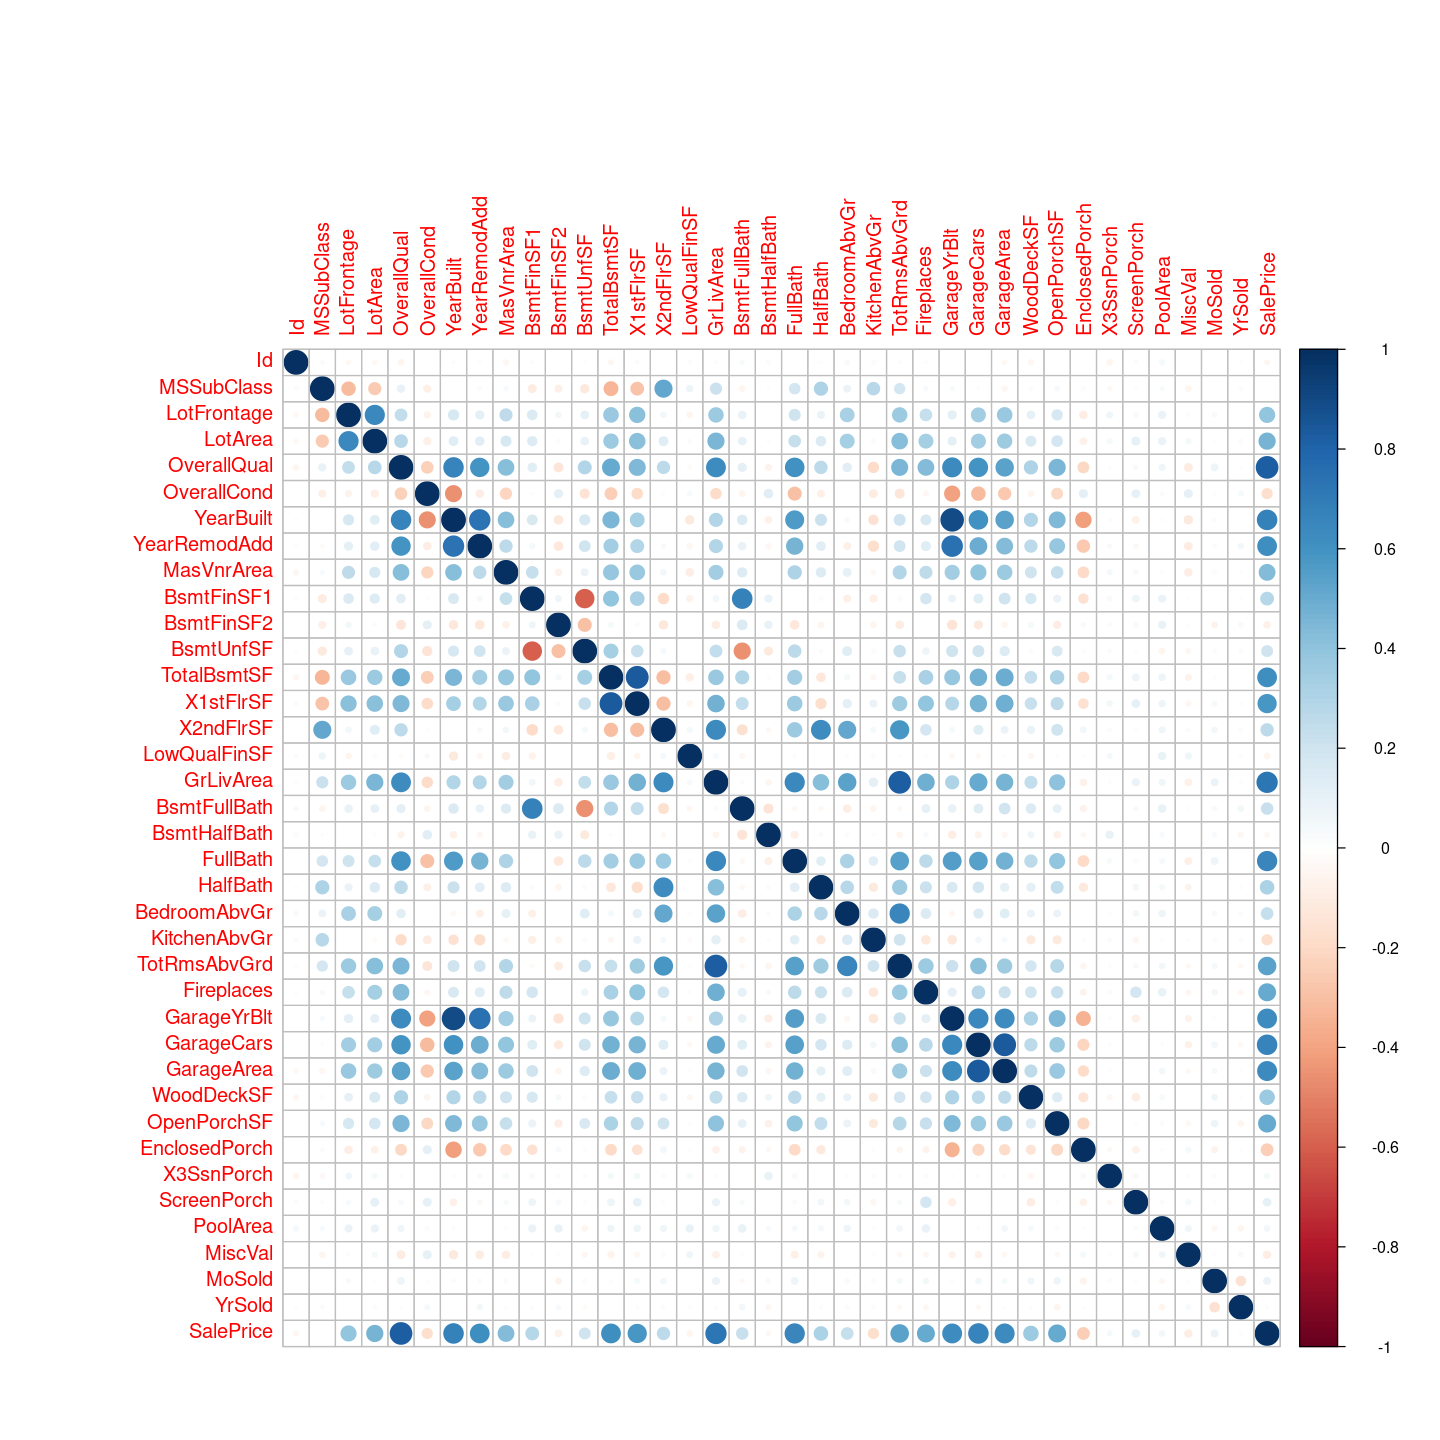

In [7]:
train_data %>%
select_if(is.numeric) %>%
cor(use = "complete.obs", method = "spearman") -> correlations

corrplot(correlations, method = "circle")

Some variables seem to provide little extra information over others, for example, YearBuilt and GarageYrBlt. This means there is quite a lot of multicolinearity in the data. This is very relevant if we want to fit a linear model.

Let's finally take a look at the variables with the highest correlation with the target variable.

In [8]:
correlations[, 38] %>% sort(decreasing = TRUE) %>% print()

    SalePrice   OverallQual     GrLivArea     YearBuilt    GarageCars 
  1.000000000   0.827108243   0.724976693   0.670198370   0.668072170 
     FullBath    GarageArea   GarageYrBlt   TotalBsmtSF  YearRemodAdd 
  0.651157919   0.631302788   0.626219262   0.618297886   0.617311189 
    X1stFlrSF  TotRmsAbvGrd   OpenPorchSF    Fireplaces       LotArea 
  0.582929810   0.538405707   0.507618069   0.503902461   0.460287410 
   MasVnrArea   LotFrontage    WoodDeckSF      HalfBath    BsmtFinSF1 
  0.435443677   0.399656951   0.366395457   0.319917623   0.285329793 
    X2ndFlrSF  BedroomAbvGr  BsmtFullBath     BsmtUnfSF   ScreenPorch 
  0.263692343   0.234986242   0.228001195   0.201583146   0.100215658 
       MoSold      PoolArea    X3SsnPorch    MSSubClass        YrSold 
  0.081914266   0.052573200   0.044933771  -0.006463019  -0.017650201 
 BsmtHalfBath            Id  LowQualFinSF    BsmtFinSF2       MiscVal 
 -0.039400439  -0.041634025  -0.053419635  -0.076097825  -0.091905807 
  Over

Overall quality, ground living area, year built, garage capacity and the number of full bathrooms are the variables most correlated with the target variable.

Let's take a look at the number of levels of each categorical variable. Variables with only two levels are transformed to numerical variables.

In [9]:
train_data <- as.data.frame(unclass(train_data), stringsAsFactors = TRUE)

train_data$Street <- as.numeric(train_data$Street)
train_data$Alley <- as.numeric(train_data$Alley)
train_data$Utilities <- as.numeric(train_data$Utilities)
train_data$CentralAir <- as.numeric(train_data$CentralAir)


# test data
test_data <- as.data.frame(unclass(test_data), stringsAsFactors = TRUE)

test_data$Street <- as.numeric(test_data$Street)
test_data$Alley <- as.numeric(test_data$Alley)
test_data$Utilities <- as.numeric(test_data$Utilities)
test_data$CentralAir <- as.numeric(test_data$CentralAir)

In [10]:
lapply(train_data, is.na) %>%
sapply(sum) %>%
sapply(function(x) x / 1460) %>%
sort(decreasing = TRUE) -> na_proportion

print(na_proportion[0:10])

      PoolQC  MiscFeature        Alley        Fence  FireplaceQu  LotFrontage 
  0.99520548   0.96301370   0.93767123   0.80753425   0.47260274   0.17739726 
  GarageType  GarageYrBlt GarageFinish   GarageQual 
  0.05547945   0.05547945   0.05547945   0.05547945 


We'll simply remove the variables with more than 20% of missing values.

In [11]:
train_data_cleaned <- subset(
    train_data,
    select = -c(PoolQC, MiscFeature, Alley, Fence, FireplaceQu)
)

test_data_cleaned <- subset(
    test_data,
    select = -c(PoolQC, MiscFeature, Alley, Fence, FireplaceQu)
)

Now, let's take a look at the variables with the highest correlation with the target variable.

Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 81 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 81 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 81 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 81 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 81 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 81 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 81 rows containing missing values”
Warning message:
“Removed 81 rows containing missing values (`geom_point()`).”
Warning message:
“

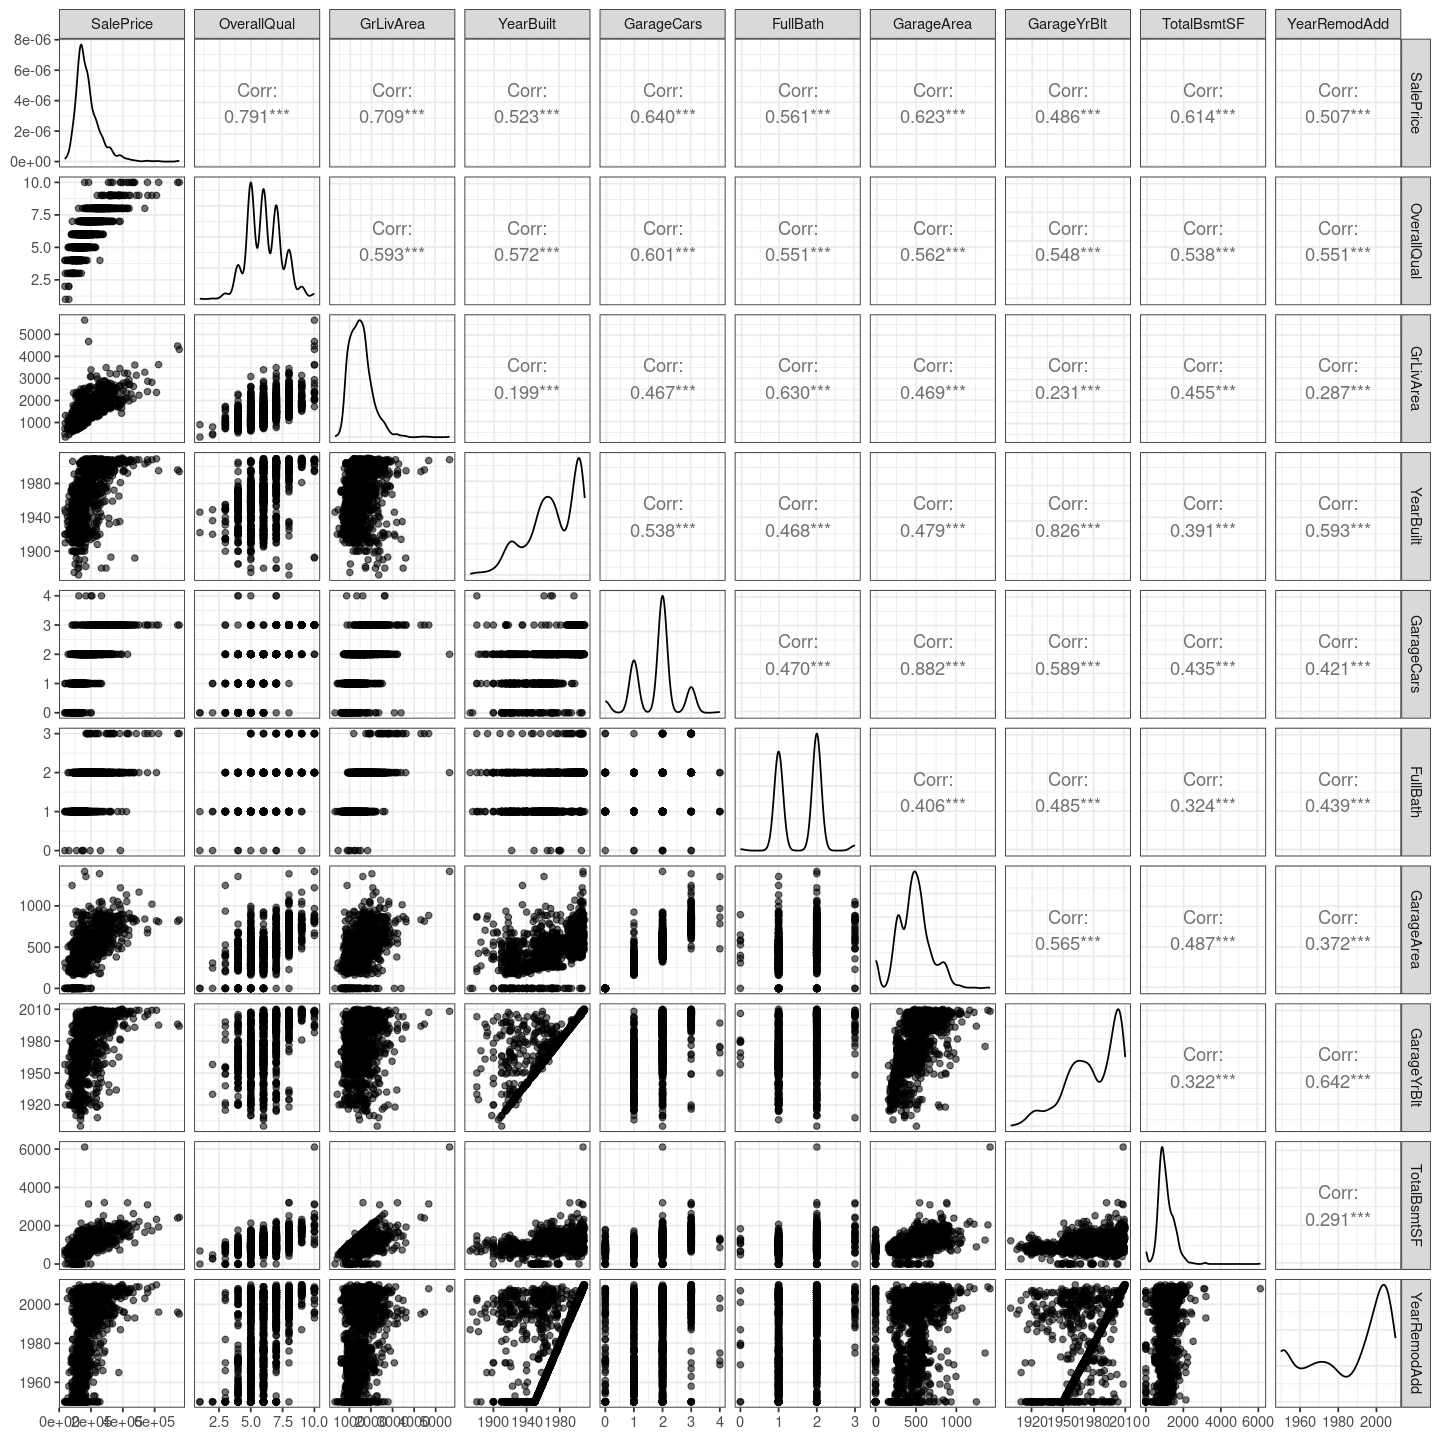

In [12]:
correlations[, 38] %>% sort(decreasing = TRUE) %>% names() -> cols

train_data %>%
dplyr::select(cols[0:10]) %>%
ggpairs(aes(alpha = 0.75)) + theme_bw()

Looking at the first column, we can see that in fact those variables seem to be positively correlated with the target variable. However, only overall quality seems to be reasonably normally distributed. Let's take a look at their distributions and transform them to get more normal-like distributions.

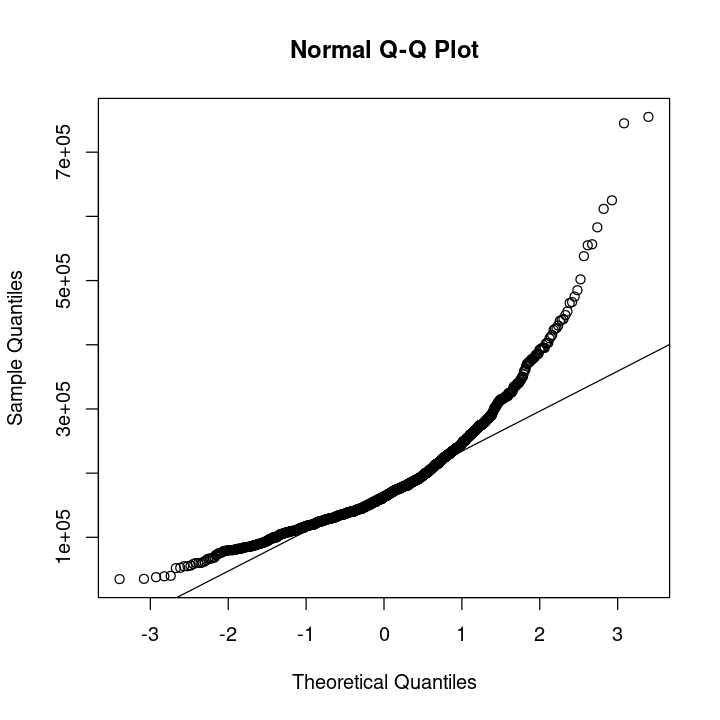

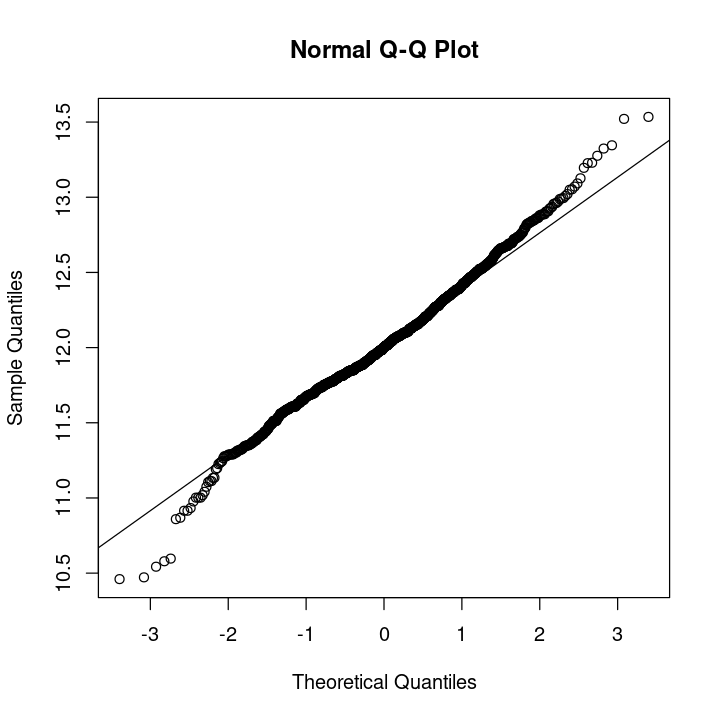

In [13]:
options(repr.plot.width = 6, repr.plot.height=6)

qqnorm(train_data_cleaned$SalePrice)
qqline(train_data_cleaned$SalePrice)

train_data_cleaned$SalePriceLog <- log(train_data_cleaned$SalePrice)
qqnorm(train_data_cleaned$SalePriceLog)
qqline(train_data_cleaned$SalePriceLog)

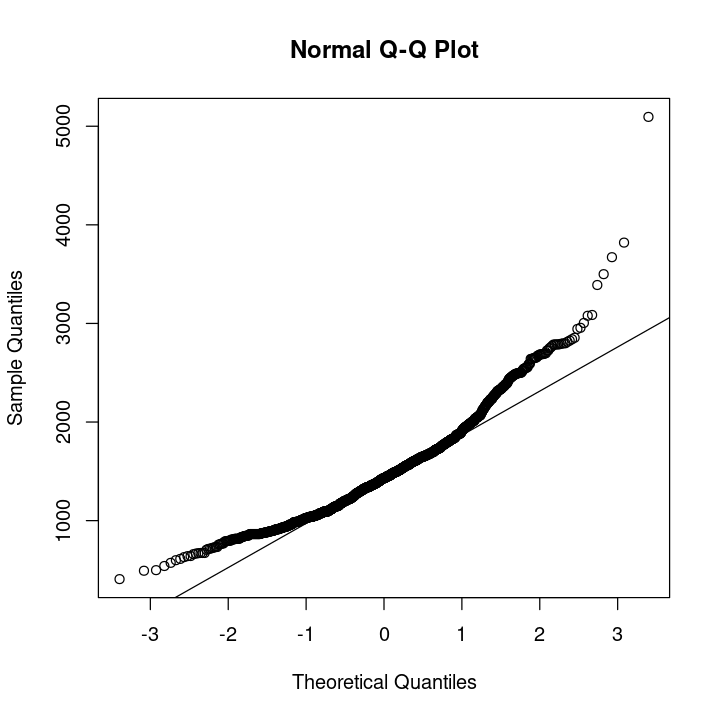

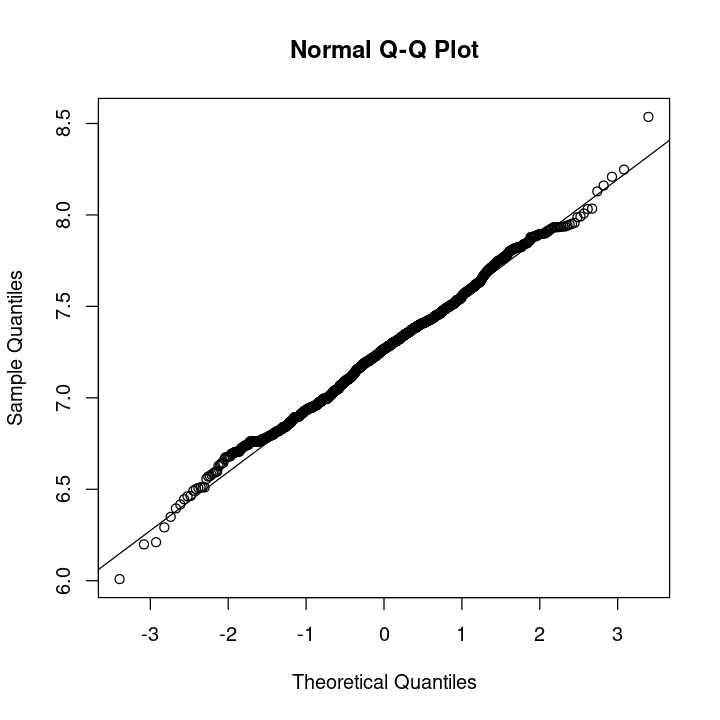

In [14]:
qqnorm(test_data_cleaned$GrLivArea)
qqline(test_data_cleaned$GrLivArea)

train_data_cleaned$GrLivAreaLog <- log(train_data_cleaned$GrLivArea)
test_data_cleaned$GrLivAreaLog <- log(test_data_cleaned$GrLivArea)
qqnorm(test_data_cleaned$GrLivAreaLog)
qqline(test_data_cleaned$GrLivAreaLog)

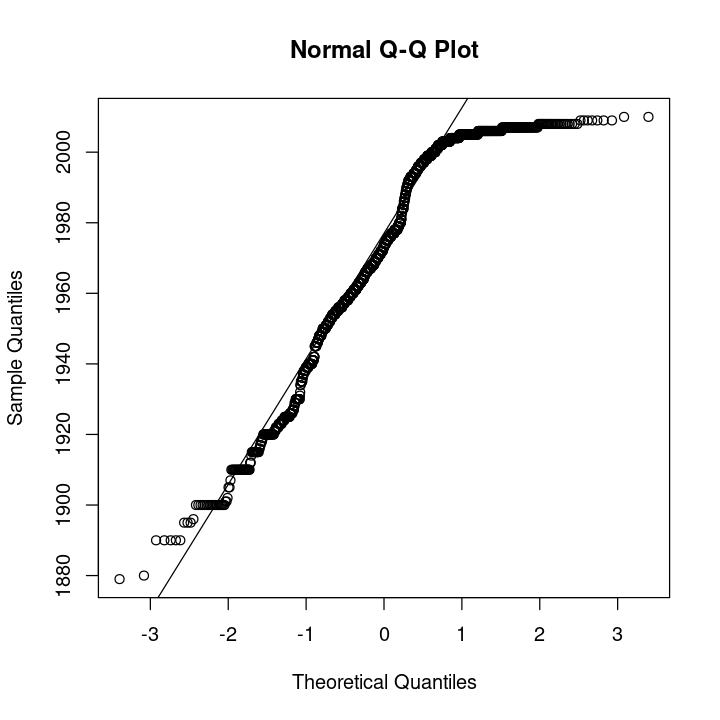

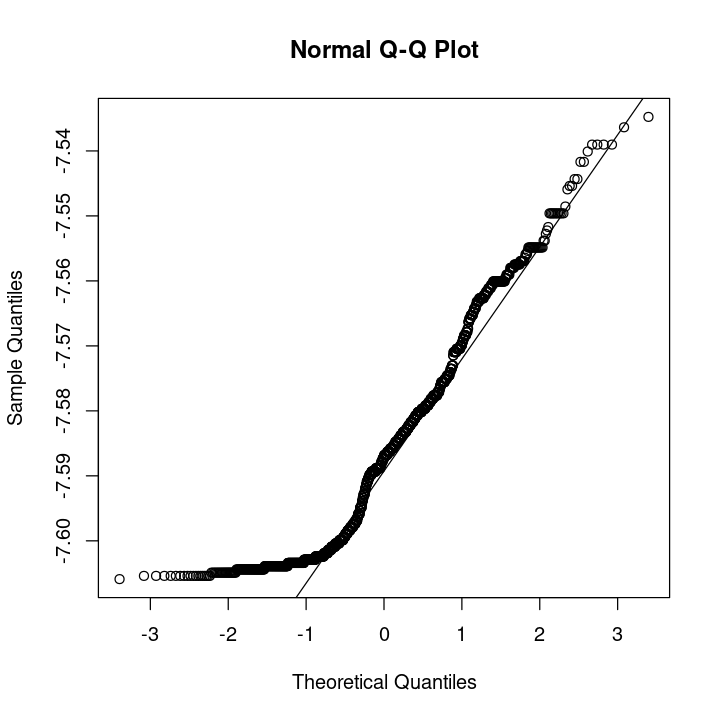

In [15]:
qqnorm(test_data_cleaned$YearBuilt)
qqline(test_data_cleaned$YearBuilt)

train_data_cleaned$YearBuiltLogInv <- log(1 / train_data_cleaned$YearBuilt)
test_data_cleaned$YearBuiltLogInv <- log(1 / test_data_cleaned$YearBuilt)
qqnorm(train_data_cleaned$YearBuiltLogInv)
qqline(train_data_cleaned$YearBuiltLogInv)

This one is so skewed the transformation is not enough to make it normal.

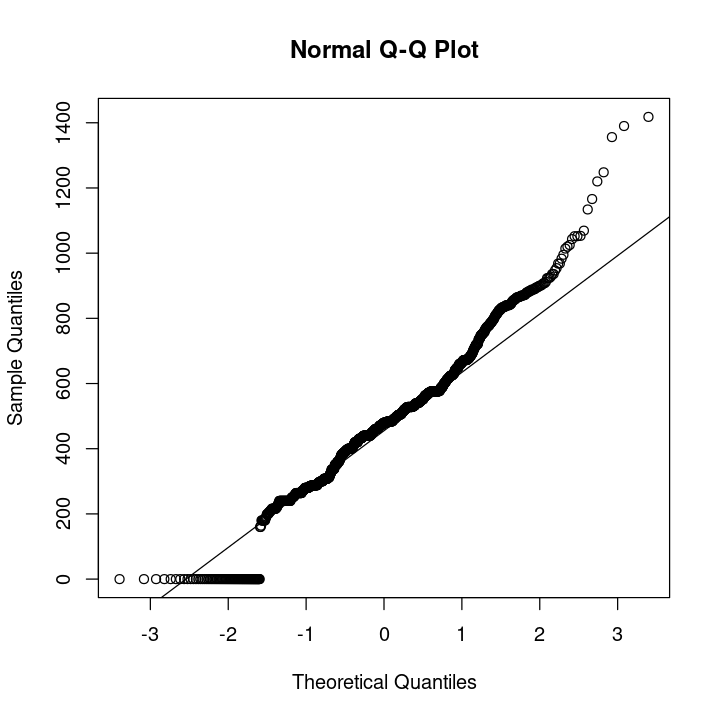

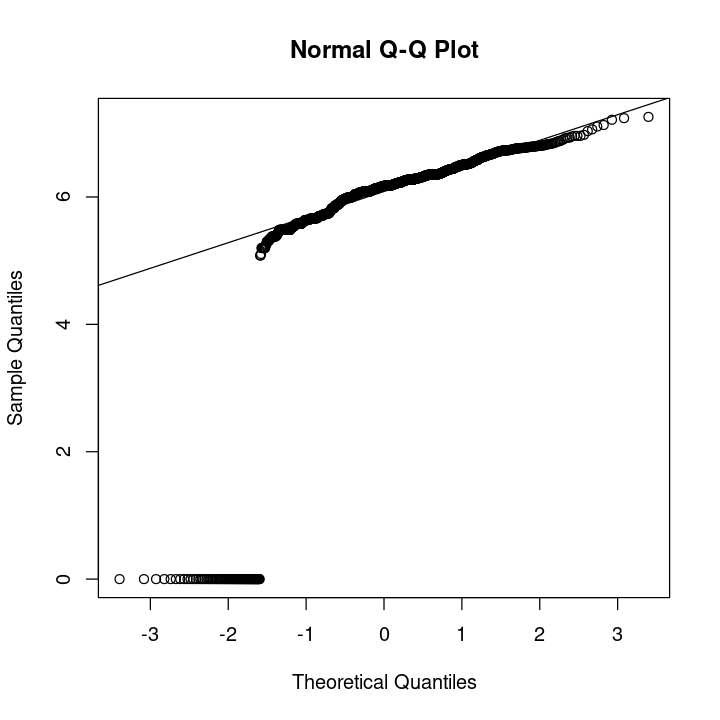

In [16]:
qqnorm(train_data_cleaned$GarageArea)
qqline(train_data_cleaned$GarageArea)

train_data_cleaned$GarageAreaLog <- log(train_data_cleaned$GarageArea + 1)
test_data_cleaned$GarageAreaLog <- log(test_data_cleaned$GarageArea + 1)
qqnorm(train_data_cleaned$GarageAreaLog)
qqline(train_data_cleaned$GarageAreaLog)

Since this one has a lot of zeros, we'll create a new variable indicating if a garage is present or not. We'll also turn the zero values into NAs.

In [17]:
train_data_cleaned$GaragePresent <- as.numeric(
    train_data_cleaned$GarageArea > 0
)
train_data_cleaned$GarageAreaLog <- ifelse(
    train_data_cleaned$GaragePresent,
    train_data_cleaned$GarageAreaLog,
    NA
)

summary(train_data_cleaned$GarageAreaLog)
summary(train_data_cleaned$GaragePresent)

test_data_cleaned$GaragePresent <- as.numeric(test_data_cleaned$GarageArea > 0)
test_data_cleaned$GarageAreaLog <- ifelse(
    test_data_cleaned$GaragePresent,
    train_data_cleaned$GarageAreaLog,
    NA
)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  5.081   5.943   6.184   6.149   6.365   7.258      81 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.9445  1.0000  1.0000 

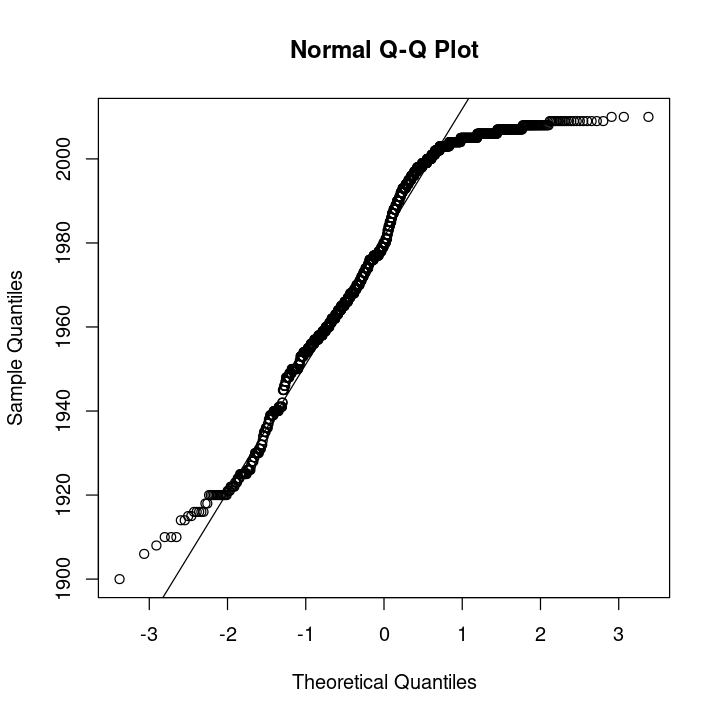

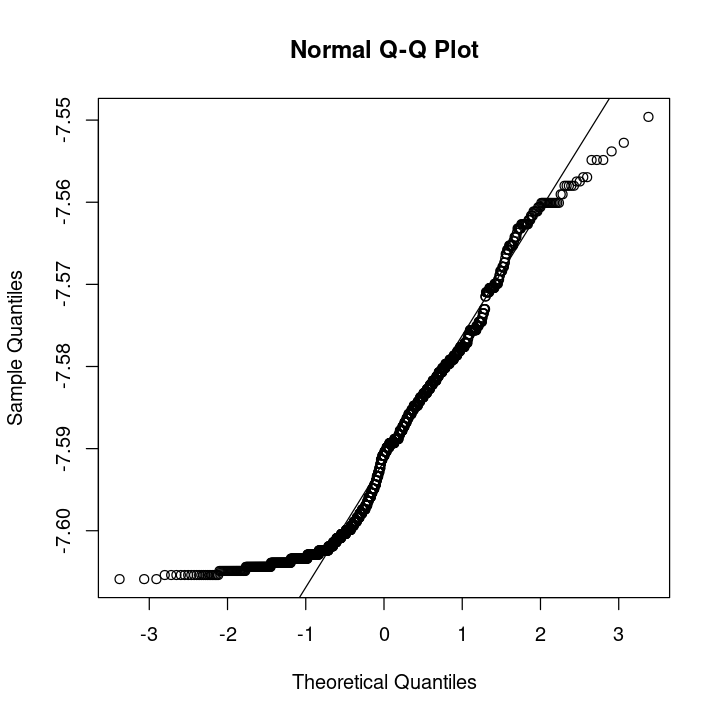

In [18]:
qqnorm(train_data_cleaned$GarageYrBlt)
qqline(train_data_cleaned$GarageYrBlt)

train_data_cleaned$GarageYrBltLogInv <- log(1 / train_data_cleaned$GarageYrBlt)
test_data_cleaned$GarageYrBltLogInv <- log(1 / test_data_cleaned$GarageYrBlt)
qqnorm(train_data_cleaned$GarageYrBltLogInv)
qqline(train_data_cleaned$GarageYrBltLogInv)

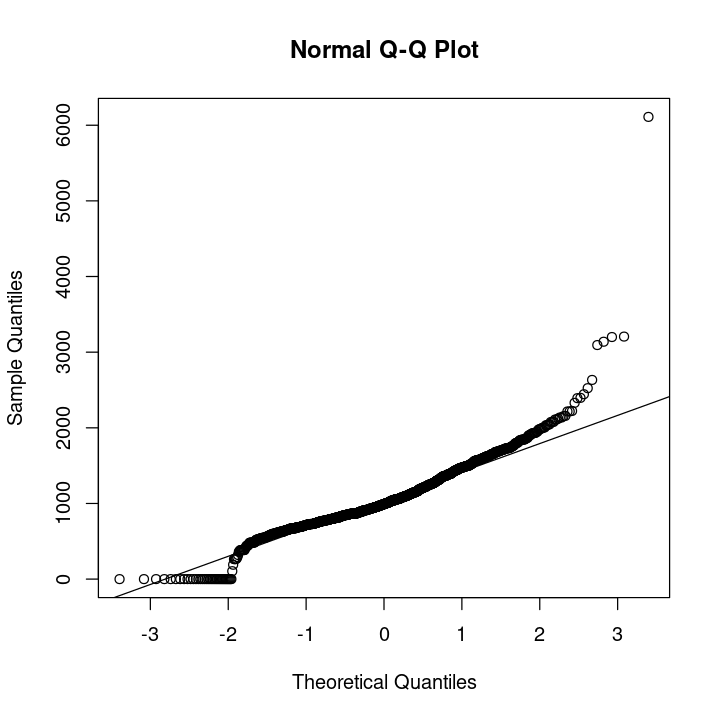

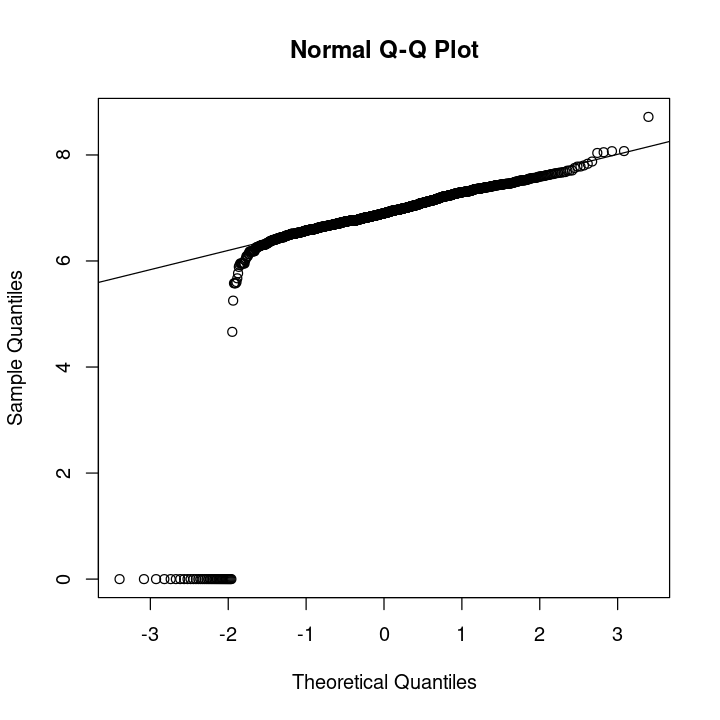

In [19]:
qqnorm(train_data_cleaned$TotalBsmtSF)
qqline(train_data_cleaned$TotalBsmtSF)

train_data_cleaned$TotalBsmtSFLog <- log(1 + train_data_cleaned$TotalBsmtSF)
test_data_cleaned$TotalBsmtSFLog <- log(1 + test_data_cleaned$TotalBsmtSF)
qqnorm(train_data_cleaned$TotalBsmtSFLog)
qqline(train_data_cleaned$TotalBsmtSFLog)

Again, it's useful to create a new variable indicating if a basement is present or not and turn zeros into NAs.

In [20]:
train_data_cleaned$BasementPresent <- as.numeric(
    train_data_cleaned$TotalBsmtSF > 0
)
train_data_cleaned$TotalBsmtSFLog <- ifelse(
    train_data_cleaned$BasementPresent,
    train_data_cleaned$TotalBsmtSFLog,
    NA
)
summary(train_data_cleaned$TotalBsmtSFLog)
summary(train_data_cleaned$BasementPresent)

test_data_cleaned$BasementPresent <- as.numeric(
    test_data_cleaned$TotalBsmtSF > 0
)
test_data_cleaned$TotalBsmtSFLog <- ifelse(
    test_data_cleaned$BasementPresent,
    train_data_cleaned$TotalBsmtSFLog,
    NA
)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  4.663   6.699   6.913   6.926   7.178   8.718      37 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.9747  1.0000  1.0000 

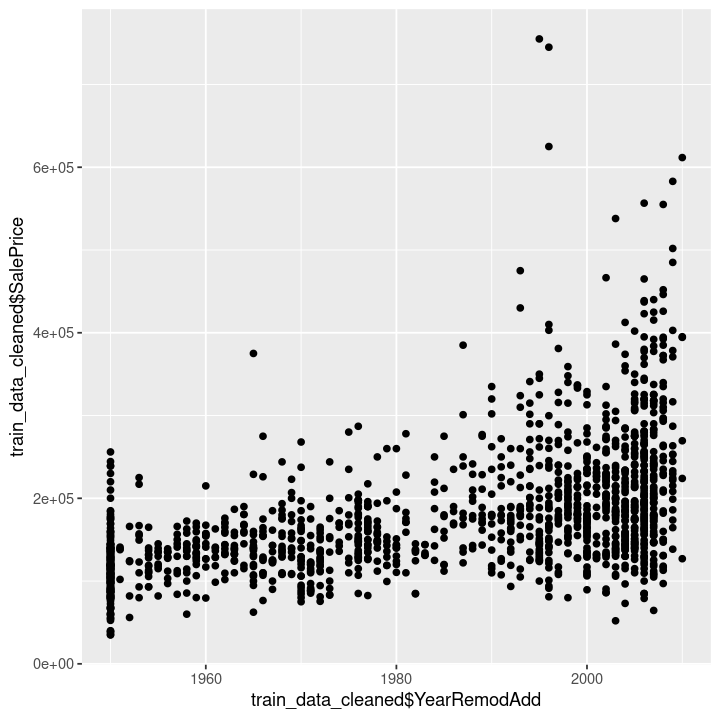

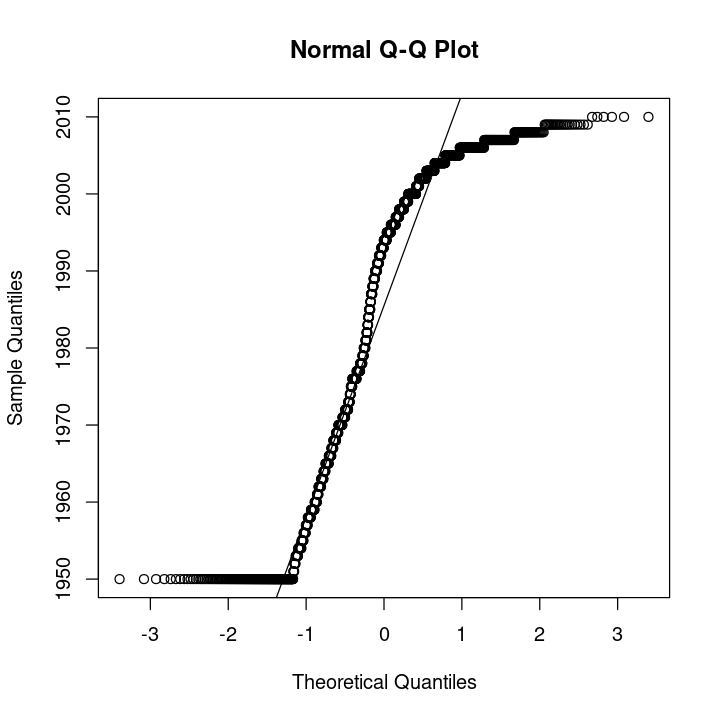

In [21]:
qplot(
    train_data_cleaned$YearRemodAdd,
    train_data_cleaned$SalePrice,
    geom = "point"
)
qqnorm(train_data_cleaned$YearRemodAdd)
qqline(train_data_cleaned$YearRemodAdd)

This is again too skewed and there's also a suspicious excess of 1950s in this variable. For this reason, We'll binarize this variable around 1985 (by visual inspection).

In [22]:
train_data_cleaned$YearRemodAddBinary <- as.numeric(
    train_data_cleaned$YearRemodAdd >= 1985
)
summary(train_data_cleaned$YearRemodAddBinary)

test_data_cleaned$YearRemodAddBinary <- as.numeric(
    test_data_cleaned$YearRemodAdd >= 1985
)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   0.576   1.000   1.000 

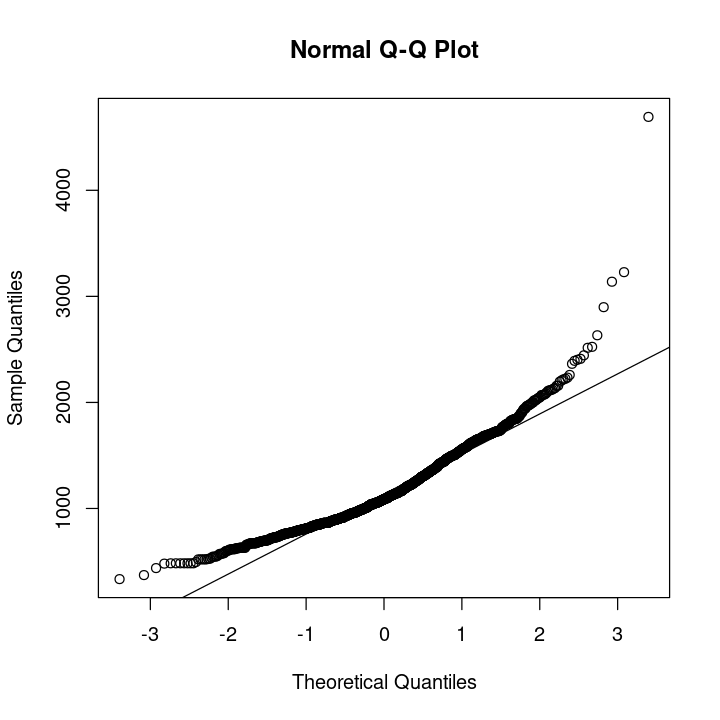

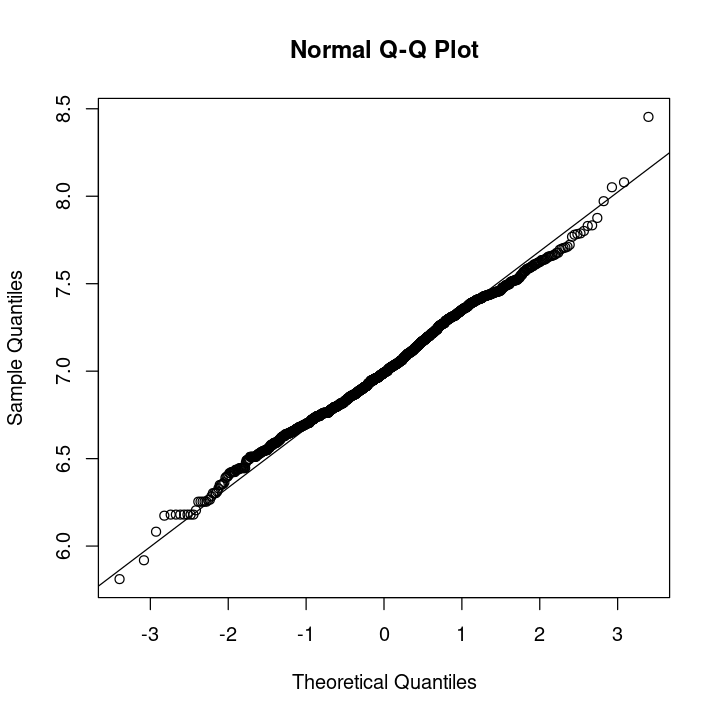

In [23]:
qqnorm(train_data_cleaned$X1stFlrSF)
qqline(train_data_cleaned$X1stFlrSF)

train_data_cleaned$X1stFlrSFLog <- log(train_data_cleaned$X1stFlrSF)
test_data_cleaned$X1stFlrSFLog <- log(test_data_cleaned$X1stFlrSF)
qqnorm(train_data_cleaned$X1stFlrSFLog)
qqline(train_data_cleaned$X1stFlrSFLog)

Perfect, now we have a data table with transformed variables and some new ones for those that are most correlated with the target variable. Let's visualize again the correlation patterns between the target variables and the transformed variables.

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(transformed_cols)

  # Now:
  data %>% select(all_of(transformed_cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 81 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 81 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 37 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 81 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 81 rows containing missing values”
Warning message in ggally_statistic(data = 

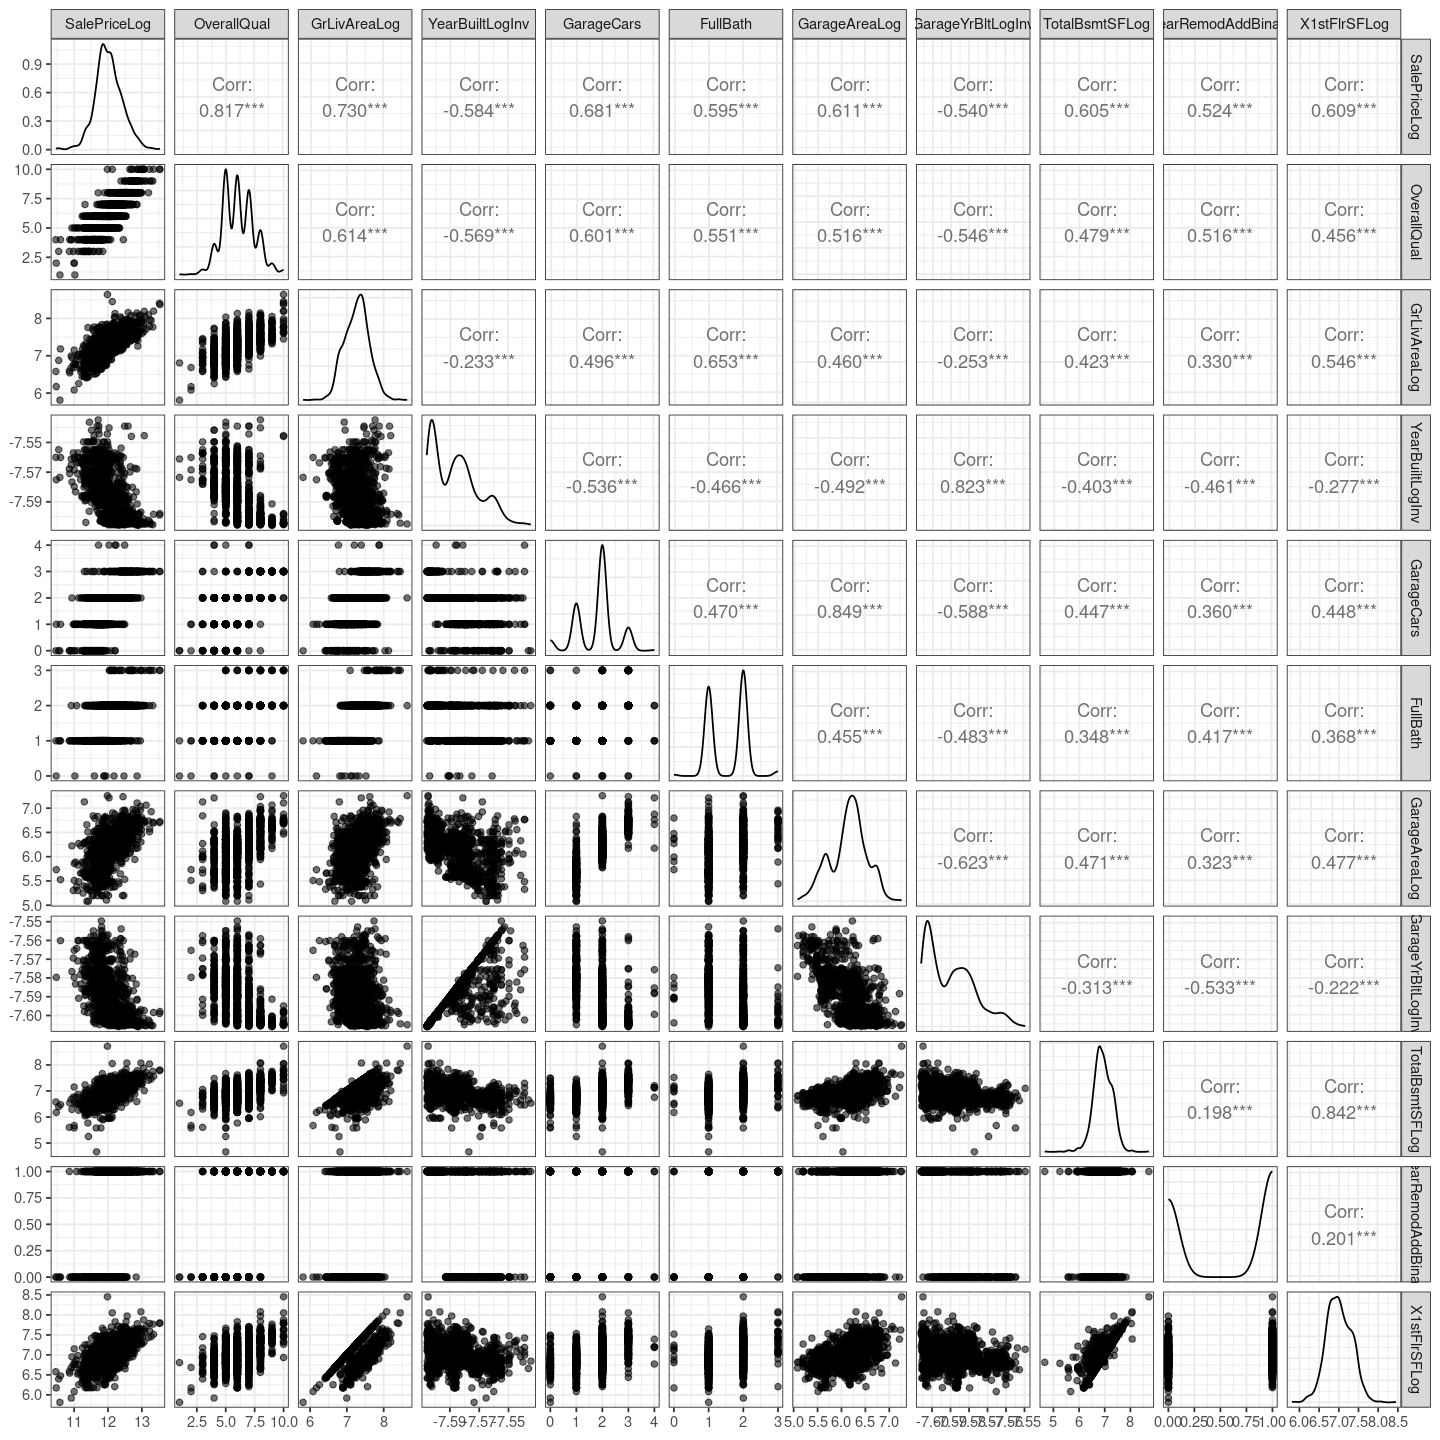

In [24]:
options(repr.plot.width = 12, repr.plot.height = 12)

transformed_cols = c(
    "SalePriceLog", "OverallQual", "GrLivAreaLog",
    "YearBuiltLogInv", "GarageCars", "FullBath",
    "GarageAreaLog", "GarageYrBltLogInv", "TotalBsmtSFLog",
    "YearRemodAddBinary", "X1stFlrSFLog")

train_data_cleaned %>%
dplyr::select(transformed_cols) %>%
ggpairs(aes(alpha = 0.75)) + theme_bw()

The first column looks better now with the transformed variables. Let's split the data into train and validation sets and then fit a simple linear regression model.

In [25]:
set.seed(42)
split_index <- caret::createDataPartition(
    train_data_cleaned$SalePriceLog, p = 0.8, list = FALSE
)
train_data_cleaned_train <- train_data_cleaned[split_index, ]
train_data_cleaned_val <- train_data_cleaned[-split_index, ]

In [26]:
formula <- paste(
    "SalePriceLog ~ ",
    paste(transformed_cols[-1], collapse = " + "),
    sep = ""
)

linear_model <- lm(formula, data = train_data_cleaned_train)

summary(linear_model)


Call:
lm(formula = formula, data = train_data_cleaned_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.46627 -0.07574  0.00317  0.09037  0.50348 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -14.493405   4.762751  -3.043  0.00240 ** 
OverallQual          0.094796   0.006033  15.714  < 2e-16 ***
GrLivAreaLog         0.395098   0.025359  15.580  < 2e-16 ***
YearBuiltLogInv     -4.588059   0.629362  -7.290 6.04e-13 ***
GarageCars           0.044193   0.015529   2.846  0.00451 ** 
FullBath            -0.029837   0.013263  -2.250  0.02467 *  
GarageAreaLog        0.072309   0.026806   2.697  0.00710 ** 
GarageYrBltLogInv    1.799456   0.810786   2.219  0.02667 *  
TotalBsmtSFLog       0.115832   0.028834   4.017 6.31e-05 ***
YearRemodAddBinary   0.089917   0.012896   6.973 5.46e-12 ***
X1stFlrSFLog         0.085352   0.032888   2.595  0.00958 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residua

Let's calculate the root mean squared error, which is the metric used in this competition.

In [27]:
predictions <- linear_model %>% predict(train_data_cleaned_val)
data.frame(
    RMSE = RMSE(
        predictions,
        train_data_cleaned_val$SalePriceLog,
        na.rm = TRUE
        ),
    R2 = R2(
        predictions,
        train_data_cleaned_val$SalePriceLog,
        na.rm = TRUE
        )
) %>% print()

       RMSE        R2
1 0.1517073 0.8161359


From the correlation plots we can see there's quite some multicolinearity happening here. Still, the model doesn't seem all that bad with R^2 = 0.82.

We should take this with a grain of salt since there are far too many categorical variables and levels and too much multicolinearity. It's a good idea to either use a form of variable selection such as lasso or another type of model that can implicitly handle the excess of variables.

We'll start with lasso and ridge penalized regression.

In [28]:
near_zero_var <- caret::nearZeroVar(train_data_cleaned_train)
train_data_variance <- train_data_cleaned_train[, -near_zero_var]

lambdas <- 10 ^ seq(-5, 5, length = 100)

ridge <- caret::train(
    SalePriceLog ~ .,
    data = train_data_variance[, -which(
        names(train_data_variance) == "SalePrice"
        )],
    method = "glmnet",
    trControl = trainControl("cv", number = 5),
    tuneGrid = expand.grid(alpha = 0, lambda = lambdas),
    na.action = na.omit
)

lasso <- caret::train(
    SalePriceLog ~ .,
    data = train_data_variance[, -which(
        names(train_data_variance) == "SalePrice"
        )],
    method = "glmnet",
    trControl = trainControl("cv", number = 5),
    tuneGrid = expand.grid(alpha = 1, lambda = lambdas),
    na.action = na.omit
)

elastic <- caret::train(
    SalePriceLog ~ .,
    data = train_data_variance[, -which(
        names(train_data_variance) == "SalePrice"
        )],
    method = "glmnet",
    trControl = trainControl("cv", number = 5),
    tuneLength = 10,
    na.action = na.omit
)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


Let's check which were the optimal lambdas and the RMSE for these models.

In [29]:
print("Ridge reggression:")
print(ridge$bestTune)
predictions <- ridge %>% predict(train_data_cleaned_val)
data.frame(
    RMSE = RMSE(
        predictions,
        tidyr::drop_na(train_data_cleaned_val)$SalePriceLog
        ),
    R2 = R2(
        predictions,
        tidyr::drop_na(train_data_cleaned_val)$SalePriceLog
        )
) %>% print()


print("Lasso reggression:")
print(lasso$bestTune)
predictions <- lasso %>% predict(train_data_cleaned_val)
data.frame(
    RMSE = RMSE(
        predictions,
        tidyr::drop_na(train_data_cleaned_val)$SalePriceLog
        ),
    R2 = R2(
        predictions,
        tidyr::drop_na(train_data_cleaned_val)$SalePriceLog
        )
) %>% print()

print("Elastic net reggression:")
print(lasso$bestTune)
predictions <- elastic %>% predict(train_data_cleaned_val)
data.frame(
    RMSE = RMSE(
        predictions,
        tidyr::drop_na(train_data_cleaned_val)$SalePriceLog
        ),
    R2 = R2(
        predictions,
        tidyr::drop_na(train_data_cleaned_val)$SalePriceLog
        )
) %>% print()

[1] "Ridge reggression:"
   alpha    lambda
43     0 0.1747528
      RMSE       R2
1 0.126965 0.885285
[1] "Lasso reggression:"
   alpha      lambda
25     1 0.002656088
       RMSE       R2
1 0.1261285 0.886333
[1] "Elastic net reggression:"
   alpha      lambda
25     1 0.002656088
      RMSE        R2
1 0.120636 0.8965835


So far, the best model was the simple linear model with only the top-10 most-correlated-with-outcome variables. Before continuing, let's first go back to our data and do two things:

    1) Standardize/normalize the data
    2) Remove possible outliers

Let's first check how many observations are over 4 standard deviations from the mean for each variable.

In [30]:
train_data_cleaned %>%
select_if(is.numeric) %>%
na.omit() %>%
lapply(scale) %>%
lapply(function(x) abs(x) > 3) %>%
sapply(sum) %>%
print()

                Id         MSSubClass        LotFrontage            LotArea 
                 0                 19                 10                 11 
            Street          Utilities        OverallQual        OverallCond 
                 4                 NA                  2                 16 
         YearBuilt       YearRemodAdd         MasVnrArea         BsmtFinSF1 
                 0                  0                 22                  6 
        BsmtFinSF2          BsmtUnfSF        TotalBsmtSF         CentralAir 
                38                  6                  8                 58 
         X1stFlrSF          X2ndFlrSF       LowQualFinSF          GrLivArea 
                 8                  4                 13                 13 
      BsmtFullBath       BsmtHalfBath           FullBath           HalfBath 
                11                 61                  0                  7 
      BedroomAbvGr       KitchenAbvGr       TotRmsAbvGrd         Fireplaces 

We'll clip the values to be between -3 and 3 standard deviations from the mean and then normalize all numerical variables to the range (0, 1).

In [31]:
clip <- function(vec, max=3, min=-3) pmax(min, pmin(vec, max))

train_data_cleaned %>%
select_if(is.numeric) %>%
lapply(scale) %>%
sapply(clip) %>%
data.frame() ->
train_data_scaled

train_data_scaled %>%
caret::preProcess(method = "range") ->
scaler

train_data_norm <- scaler %>% predict(train_data_scaled)

train_data_cleaned %>%
select_if(purrr::negate(is.numeric)) %>%
names() -> categorical_cols

train_data_norm <- cbind(
    train_data_norm, train_data_cleaned[, categorical_cols]
)

train_data_norm <- train_data_norm[, -which(
    names(train_data_norm) %in% c("Id", "SalePrice")
)]
train_data_norm$SalePriceLog <- train_data_cleaned$SalePriceLog

train_data_norm_train <- train_data_norm[split_index, ]
train_data_norm_val <- train_data_norm[-split_index, ]

Now we'll fit our linear models one more time.

In [32]:
formula <- paste(
    "SalePriceLog ~ ",
    paste(transformed_cols[-1], collapse = " + "),
    sep = ""
)

linear_model <- lm(formula, data = train_data_norm_train)

summary(linear_model)

(predict(linear_model, train_data_norm_val) -
    train_data_norm_val$SalePriceLog) %>%
mean(na.rm = TRUE) %>%
sqrt() -> lm_rmse

predictions <- linear_model %>% predict(train_data_norm_val)

data.frame(
    RMSE = RMSE(
        predictions,
        train_data_norm_val$SalePriceLog,
        na.rm = TRUE
        ),
    R2 = R2(
        predictions,
        train_data_norm_val$SalePriceLog,
        na.rm = TRUE
        )
) %>% print()


Call:
lm(formula = formula, data = train_data_norm_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.22507 -0.07837  0.00453  0.08884  0.50263 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        10.92880    0.03306 330.611  < 2e-16 ***
OverallQual         0.75097    0.04770  15.745  < 2e-16 ***
GrLivAreaLog        0.83073    0.05050  16.450  < 2e-16 ***
YearBuiltLogInv    -0.30240    0.04085  -7.403 2.71e-13 ***
GarageCars          0.15531    0.06118   2.539  0.01127 *  
FullBath           -0.10494    0.03923  -2.675  0.00759 ** 
GarageAreaLog       0.15874    0.05731   2.770  0.00570 ** 
GarageYrBltLogInv   0.08992    0.04278   2.102  0.03579 *  
TotalBsmtSFLog      0.29591    0.06325   4.678 3.27e-06 ***
YearRemodAddBinary  0.08971    0.01269   7.070 2.81e-12 ***
X1stFlrSFLog        0.14836    0.06274   2.365  0.01823 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1575 on

       RMSE        R2
1 0.1508153 0.8184083


In [33]:
near_zero_var <- caret::nearZeroVar(train_data_norm_train)
train_data_variance <- train_data_norm_train[, -near_zero_var]

lambdas <- 10 ^ seq(-5, 5, length = 100)
ridge <- caret::train(
    SalePriceLog ~ .,
    data = train_data_variance,
    method = "glmnet",
    trControl = trainControl("cv", number = 5),
    tuneGrid = expand.grid(alpha = 0, lambda = lambdas),
    na.action = na.omit
)

lasso <- caret::train(
    SalePriceLog ~ .,
    data = train_data_variance,
    method = "glmnet",
    trControl = trainControl("cv", number = 5),
    tuneGrid = expand.grid(alpha = 1, lambda = lambdas),
    na.action = na.omit
)

elastic <- caret::train(
    SalePriceLog ~ .,
    data = train_data_variance,
    method = "glmnet",
    trControl = trainControl("cv", number = 5),
    tuneLength = 10,
    na.action = na.omit
)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


In [34]:
print("Ridge reggression:")
print(ridge$bestTune)
predictions <- ridge %>% predict(train_data_norm_val)
data.frame(
    RMSE = RMSE(
        predictions,
        tidyr::drop_na(train_data_norm_val)$SalePriceLog
        ),
    R2 = R2(
        predictions,
        tidyr::drop_na(train_data_norm_val)$SalePriceLog
        )
) %>% print()


print("Lasso reggression:")
print(lasso$bestTune)
predictions <- lasso %>% predict(train_data_norm_val)
data.frame(
    RMSE = RMSE(
        predictions,
        tidyr::drop_na(train_data_norm_val)$SalePriceLog
        ),
    R2 = R2(
        predictions,
        tidyr::drop_na(train_data_norm_val)$SalePriceLog
        )
) %>% print()

print("Elastic net reggression:")
print(lasso$bestTune)
predictions <- elastic %>% predict(train_data_norm_val)
data.frame(
    RMSE = RMSE(
        predictions,
        tidyr::drop_na(train_data_norm_val)$SalePriceLog
        ),
    R2 = R2(
        predictions,
        tidyr::drop_na(train_data_norm_val)$SalePriceLog
        )
) %>% print()

[1] "Ridge reggression:"
   alpha    lambda
42     0 0.1384886
       RMSE        R2
1 0.1243055 0.8895991
[1] "Lasso reggression:"
   alpha      lambda
27     1 0.004229243
      RMSE       R2
1 0.128285 0.883672
[1] "Elastic net reggression:"
   alpha      lambda
27     1 0.004229243
       RMSE        R2
1 0.1279487 0.8845569


There was no clear improvement and RMSE for the penalized models even went down, so let's switch back to the un-normalized data. I think we should now switch to another more powerful model. Let's juice up and the popular Random Forest and XGBoost models.

We'll use randomForest's default parameters and doParallel to parallelize the computation. Please adjust the number of threads so your CPU doesn't explode.

In [35]:
near_zero_var <- caret::nearZeroVar(train_data_cleaned_train)
train_data_variance <- train_data_cleaned_train[, -near_zero_var]

lambdas <- 10 ^ seq(-5, 5, length = 100)

ridge <- caret::train(
    SalePriceLog ~ .,
    data = train_data_variance[, -which(
        names(train_data_variance) == "SalePrice"
        )],
    method = "glmnet",
    trControl = trainControl("cv", number = 5),
    tuneGrid = expand.grid(alpha = 0, lambda = lambdas),
    na.action = na.omit
)

lasso <- caret::train(
    SalePriceLog ~ .,
    data = train_data_variance[, -which(
        names(train_data_variance) == "SalePrice"
        )],
    method = "glmnet",
    trControl = trainControl("cv", number = 5),
    tuneGrid = expand.grid(alpha = 1, lambda = lambdas),
    na.action = na.omit
)

elastic <- caret::train(
    SalePriceLog ~ .,
    data = train_data_variance[, -which(
        names(train_data_variance) == "SalePrice"
        )],
    method = "glmnet",
    trControl = trainControl("cv", number = 5),
    tuneLength = 10,
    na.action = na.omit
)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


In [36]:
cl <- makePSOCKcluster(16)
registerDoParallel(cl)

rf_model <- caret::train(
    SalePriceLog ~ .,
    data = train_data_cleaned_train[, -which(
        names(train_data_cleaned_train) == "SalePrice"
        )],
    method = "rf",
    na.action = na.omit
)

stopCluster(cl)

In [37]:
predictions <- predict(rf_model, train_data_cleaned_val)

data.frame(
    RMSE = RMSE(
        predictions,
        tidyr::drop_na(train_data_cleaned_val)$SalePriceLog
        ),
    R2 = R2(
        predictions,
        tidyr::drop_na(train_data_cleaned_val)$SalePriceLog
        )
) %>% print()

       RMSE        R2
1 0.1368067 0.8663133


A little hack is required to finish background parallel tasks:

In [38]:
#from https://stackoverflow.com/questions/64519640/error-in-summary-connectionconnection-invalid-connection
unregister_dopar <- function() {
  env <- foreach:::.foreachGlobals
  rm(list=ls(name=env), pos=env)
}

unregister_dopar()

Not bad at all! There might be some overfitting, but I think it's a good starting point. It's time to go XGBoost.

In [39]:
train_control <- trainControl(method = "cv", number = 3)

xgb_grid <- expand.grid(nrounds = 500,
                        max_depth = seq(2, 9),
                        eta = c(0.1, 0.3, 1),
                        gamma = c(0.0, 0.01, 0.1, 1),
                        min_child_weight = c(0.5, 1, 2, 4),
                        colsample_bytree = 1,
                        subsample = 0.5
)

xgb_tune <- train(SalePriceLog ~.,
                 data = train_data_cleaned_train[, -which(
                     names(train_data_cleaned_train) == "SalePrice"
                     )],
                 method = "xgbTree",
                 metric = "RMSE",
                 trControl = train_control,
                 tuneGrid = xgb_grid,
                 na.action = na.pass
)

In [40]:
predictions <- predict(xgb_tune, train_data_cleaned_val)

data.frame(
    RMSE = RMSE(
        predictions,
        tidyr::drop_na(train_data_cleaned_val)$SalePriceLog
        ),
    R2 = R2(
        predictions,
        tidyr::drop_na(train_data_cleaned_val)$SalePriceLog
        )
) %>% print()

       RMSE        R2
1 0.1228595 0.8947312


Quite surprisingly, ridge regression is still the best model! We'll then use it to produce our test predictions. We can also contruct an ensemble with the models we've trained so far. Let's do the same scaling and outlier removal as we did for the training data.

In [41]:
print(dim(test_data_cleaned))

test_data_cleaned %>%
select_if(is.numeric) %>%
lapply(scale) %>%
sapply(clip) %>%
data.frame() ->
test_data_scaled

test_data_scaled %>%
caret::preProcess(method = "range") ->
scaler

test_data_norm <- scaler %>% predict(test_data_scaled)

test_data_cleaned %>%
select_if(purrr::negate(is.numeric)) %>%
names() -> categorical_cols

test_data_norm <- cbind(
    test_data_norm, test_data_cleaned[, categorical_cols]
)

test_data_norm <- test_data_norm[, -which(
    names(test_data_norm) %in% c("Id", "SalePrice")
)]
test_data_norm$SalePriceLog <- test_data_cleaned$SalePriceLog

print(dim(test_data_cleaned))
print(dim(test_data_norm))

[1] 1459   84


Warning message in min(x, na.rm = na.remove):
“no non-missing arguments to min; returning Inf”
Warning message in max(x, na.rm = na.remove):
“no non-missing arguments to max; returning -Inf”


[1] 1459   84
[1] 1459   83


In [42]:
predict(xgb_tune, test_data_cleaned) %>% exp() -> test_predictions
length(test_predictions)

submission <- data.frame(
    Id = test_data$Id,
    SalePrice = test_predictions
)

write.csv(submission, "submission.csv")

[1] 1021

ERROR: Error in data.frame(Id = test_data$Id, SalePrice = test_predictions): arguments imply differing number of rows: 1459, 1021
